In [117]:
# Imports

from typing import List
from random import random as rand
import pathlib as pl
import os, math, np, copy
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, Label

from IPython.display import display

In [118]:
# Defining widgets
layout = widgets.Layout(width='auto', height='40px') #set width and height

w_populatie = widgets.IntSlider(value = 25, min = 10, max = 2000, step = 5,)
w_domeniu = widgets.IntRangeSlider(value = [-1, 2], min = -100, max = 100, step = 1)
w_function = widgets.Text(value = '-1 * x**2 + x + 2', 
    placeholder = 'Functie in x, ex: 3 * x + 2')
w_precizie = widgets.IntSlider(value = 6, min = 1, max = 15, step = 1)
w_prob_recomb = widgets.FloatSlider(value=0.25, min = 0, max = 1, step = 0.01)
w_prob_mutatie = widgets.FloatSlider(value=0.01, min = 0, max = 1, step = 0.01)
w_tip_mutatie = widgets.ToggleButtons(
    options=['Mutatie rara', 'Mutatie comuna'])
w_generatii = widgets.IntSlider(value = 400, min = 10, max = 1250, step = 5)
w_secondary = widgets.IntSlider(value = 15, min = 0, max = 100, step = 1)

In [119]:
# Definirea constantelor

FILENAME = "Evolutie.txt"

# Decide comportamentul algoritmului genetic

# selectia (daca se aleg mai multe strategii, este folosita doar una dintre ele, 
# cu prioritatea in ordinea data)
# Numai una din selectii trebuie sa aiba valoarea 1 (oricum doar una este folosita)
SEL_PROPORTIONALA = 1
SEL_ORDONARE = 0
SEL_TURNEU = 0

# SEL_ELITISTA = 1
# Daca se foloseste selectia turneu, marimea unei runde de selectie
SEL_TURNEU_SIZE = 10

# daca folosim operatorul de mutatie
# Recomandat sa fie folosita exact 1 dintre variante
# Doar una dintre ele va fi folosita, valoare extrasa din interfata grafica, vezi setGlobals
ALG_MUTATIE_DEASA = 0
ALG_MUTATIE_RARA = 1

# Constantele problemei
DIM_POP = w_populatie.value
DOM_A, DOM_B = w_domeniu.value
PRECIZIE = w_precizie.value  # O putere de 10, -->> 10^PRECIZIE
X_FUNC = w_function.value
P_REC, P_MUT = w_prob_recomb.value, w_prob_mutatie.value
EPOCHS = w_generatii.value

# Aceasta functie reincarca variabilele globale 
# pentru a corespunde cu cele din interfata grafica
def setGlobals():
    global DIM_POP
    global DOM_A, DOM_B
    global PRECIZIE
    global X_FUNC
    global P_REC, P_MUT
    global EPOCHS
    global SECONDARY_PERCENT
    global ALG_MUTATIE_DEASA, ALG_MUTATIE_RARA
    
    ALG_MUTATIE_DEASA, ALG_MUTATIE_RARA = 0, 0

    if w_tip_mutatie.value == 'Mutatie rara':
        ALG_MUTATIE_RARA = 1
    else:
        ALG_MUTATIE_DEASA = 1
    
    SECONDARY_PERCENT = w_secondary.value  # Top cat % urmaresc performanta medie si cea mai proasta 
    DIM_POP = w_populatie.value
    DOM_A, DOM_B = w_domeniu.value
    PRECIZIE = w_precizie.value  # O putere de 10, -->> 10^PRECIZIE
    X_FUNC = w_function.value
    P_REC, P_MUT = w_prob_recomb.value, w_prob_mutatie.value
    EPOCHS = w_generatii.value

In [120]:
# Functie pentru a face mai scurt un deep-copy
def mycp(x):
    return copy.deepcopy(x)
    

In [121]:
# Individ stuff

class Individ:
    # Cream clasa individ dandu-se o lista de 0/1
    def __init__(self, bits: List[int]):
        self.bits = bits
    
    # Pentru a putea transforma in string un Individ
    def __str__(self):
        return f'Individ (bits = {self.bits})'
    
    # Pentru a putea afisa in interactor clasa Individ
    def __repr__(self):
        return self.__str__()
    
    # Returneaza x-ul asociat cromozomului
    def get_x(self):
        l = len(self.bits)
        val = 0
        for b in self.bits:
            val = val * 2 + b
        return DOM_A + (DOM_B - DOM_A) / (2**l - 1) * val
    
    # Returneaza valoarea functiei evaluata in X-ul asociat cromozomului
    def get_val(self):
        def myfunction(x):
            return eval(X_FUNC)
        val = self.get_x()
        return myfunction(val)

    # Modifica Individul 
    # Mutatie rara asupra individului
    def rare_mutation(self):
        pos = int(math.floor(rand() * len(self.bits)))
        self.bits[pos] = 1 - self.bits[pos]
    
    # Mutatie deasa asupra individului
    def often_mutation(self, probability):
        for i in range(len(self.bits)):
            if rand() < probability:
                self.bits[i] = 1 - self.bits[i]
                
    # O reprezentare ca string a cromozomului
    def tostr(self):
        mystr = "".join(["1" if bit == 1 else "0" for bit in self.bits])
        return f"{mystr}  x = {self.get_x():.5f}  f = {self.get_val():.8f}"

# Incrucisam cromozomii <a>, <b> returnand cei 2 cromozomi rezultati
def incruciseaza_2(a: Individ, b: Individ):
    pos = int(math.floor(rand() * len(a.bits)))
#     print("Rand pos: ", pos)
    
    x, y = mycp(a.bits[:pos] + b.bits[pos:]), mycp(b.bits[:pos] + a.bits[pos:])
    
    return Individ(x), Individ(y)

# Incrucisam cromozomii <a>, <b>, <c> returnand cei 3 cromozomi rezultati
def incruciseaza_3(a: Individ, b: Individ, c: Individ):
    pos = int(math.floor(rand() * len(a.bits)))
#     print("Rand pos: ", pos)
#     print("a before: ", a.bits)
    x, y, z = mycp(a.bits[:pos] + b.bits[pos:]), mycp(b.bits[:pos] + c.bits[pos:]), mycp(c.bits[:pos] + a.bits[pos:])
#     print("a after:  ", x)
    return Individ(x), Individ(y), Individ(z)

# Generam random un cromozom de o anumita lungime
def gen_random(lg: int):
    return Individ([1 if rand() < 0.5 else 0 for x in range(lg)])

In [122]:
# Utils
def sortGeneration(generatie):
    return sorted(generatie, key=lambda x: x.get_val(), reverse=True)

In [123]:
# Procesul de selectie al cromozomilor
# Din <generatie>, alegem <alesi> cromozomi
def Selectare(generatie, alesi, out_file = None):
    # Salvam cromozomii in ordinea sortata duap performanta, 
    # si in cea initiala pentru a salva schimbarile in fisierul txt
    zipped = sorted([(x.get_val(), x) for x in generatie], 
        key = lambda x: x[0])
    sorted_el = [x[1] for x in zipped]
    total_sum = sum([x[0] for x in zipped])
    sorted_ws = [x[0] / total_sum for x in zipped]
    el = generatie
    ws = [x.get_val() / total_sum for x in generatie]
    
    log_selectie_probs(generatie, ws, out_file)
    
    rank_sum = sum([i + 1 for i in range(len(zipped))])
    rank_weights = [(i + 1) / rank_sum for i in range(len(zipped))]

    selected = []
    
    # In functie de criteriul de selectie ales, facem selectia
    while len(selected) < alesi:
#         print("selecting another guy")
        if SEL_PROPORTIONALA:
            draw = np.random.choice(el, 1, p = ws)
            selected += copy.deepcopy(draw.tolist())
#             print("Alegere proportionala: ", draw)
        elif SEL_ORDONARE:
            draw = np.random.choice(sorted_el, 1, p = rank_weights)
            selected += copy.deepcopy(draw.tolist())
#             print("Alegere ordonare: ", draw)
        elif SEL_TURNEU:
            draw = np.random.choice(el, SEL_TURNEU_SIZE)
            best_guy = None
            for dude in draw:
                if best_guy == None:
                    best_guy = dude
                elif dude.get_val() > best_guy.get_val():
                    best_guy = dude
            selected += copy.deepcopy([best_guy])
#             print("Alegere turneu")
    
    log_selectie(selected, out_file)
    
    return selected

# Subrutina pentru a selectiona cel mai bun cromozom
# Din <generatie>, alegem elita compusa din un numar de <alesi> cromozomi
def SelectElita(generatie, alesi, out_file):
    zipped = sorted([(x.get_val(), x) for x in generatie], 
        key = lambda x: x[0])
    elita = []
    for i in range(alesi):
        elita += [mycp(zipped[-(1 + i)][1])]
    
    log_selectie_elita(elita, out_file)
    
    return elita

# Aplica operatorii de recombinare si mutatie
# Aplicam mutatiile asupra cromozomilor din <generatie>
def Mutatii(generatie, out_file):
    # Incrucisare
    # Alegem pozitiile peste care incrucisam
    N = len(generatie)
    pozitii = np.random.choice(list(range(N)), int(P_REC * N))
    log_Ales_Mutatii(generatie, pozitii, out_file)
    
    ind = 0
    while ind + 1 < len(pozitii):
        # Daca am un numar impar
        if (len(pozitii) - ind) % 2 == 1:
            # Daca am selectat un numar impar de candidati, tratam 3 dintre ei impreuna
            log_before(generatie, [pozitii[ind], pozitii[ind + 1], pozitii[ind + 2]], out_file)
            a, b, c = incruciseaza_3(generatie[pozitii[ind]], generatie[pozitii[ind + 1]], generatie[pozitii[ind + 2]])
            generatie[pozitii[ind]], generatie[pozitii[ind + 1]], generatie[pozitii[ind + 2]] = a, b, c
            log_after(generatie, [pozitii[ind], pozitii[ind + 1], pozitii[ind + 2]], out_file)
            ind += 3
        else:
            # Incrucisam 2 cromozomi
            log_before(generatie, [pozitii[ind], pozitii[ind + 1]], out_file)
            a, b = incruciseaza_2(generatie[pozitii[ind]], generatie[pozitii[ind + 1]])
            generatie[pozitii[ind]], generatie[pozitii[ind + 1]] = a, b
            log_after(generatie, [pozitii[ind], pozitii[ind + 1]], out_file)
            ind += 2
    
    log_Pop(generatie, out_file, "\nDupa recombinare:")
    
    mod_mut = [0] * N
    # Mutatii
    for i in range(len(generatie)):
        # Pentru a nu performa mutatii peste toti cromozomii, 
        # aplicam o mutatie cu probabilitatea Mutatiei
        if (rand() > P_MUT):
            continue
        mod_mut[i] = 1
        # Aplicam mutatia deasa sau rara, in functie de alegere
        if ALG_MUTATIE_DEASA:
            generatie[i].often_mutation(P_MUT)
        elif ALG_MUTATIE_RARA:
            generatie[i].rare_mutation()
            
    log_Pop_Mutatie(generatie, mod_mut, out_file)
            
    return generatie
        
# Ruleaza olgoritmul genetic folosindu-se de variabilele globale ca parametrii
def Simuleaza(out_file = None):
    Len = math.ceil(math.log(10**PRECIZIE * (DOM_B - DOM_A), 2))
    
    # Generam la intamplare prima generatie
    generatie = [gen_random(Len) for x in range(DIM_POP)]
    
    log_Pop(generatie, out_file, "Populatia initiala:")
    
    all_gens = [copy.deepcopy(generatie)]
    for e in range(EPOCHS):
        if e >= 1:
            out_file = None
        
        # Pastram cel mai bun cromozom
        NR_ELITA = 1
        elita = SelectElita(generatie, NR_ELITA, out_file)
        # Pentru restul aplicam algoritmul de selectare
        generatie = Selectare(generatie, DIM_POP - NR_ELITA, out_file)
        # Din cei selectati, aplicam operatorii de recombinare si mutatie
        generatie = Mutatii(generatie, out_file)
        
        generatie += elita
        
        log_Pop(generatie, out_file, "\nGeneratia urmatoare:")
        if out_file == None:
            log_best(generatie, FILENAME)
            
        
        # Salvam datele pentru grafice
        all_gens.append(copy.deepcopy(generatie))
        
    return all_gens


In [124]:
# Save to file stuff
def resetfile(out_file):
    if out_file == None:
        return
    f = open(out_file, "w")
    f.close()

def log_best(generatie, out_file):
    if out_file == None:
        return
    f = open(out_file, "a")
    f.write(f"Best performer: {get_best(generatie).get_val()}\n\n")
    f.close()
    
def log_Pop(generatie, out_file, message):
    if out_file == None:
        return
    f = open(out_file, "a")
    f.write(message + "\n")
    for i, x in enumerate(generatie):
        f.write(str(i + 1).rjust(3, ' ') + f": {x.tostr()}")
    f.close()
    log_best(generatie, out_file)
    
def log_selectie_probs(generatie, weights, out_file):
    if out_file == None:
        return
    f = open(out_file, "a")
    f.write("\nProbabilitati selectie:\n")
    
    for i, x in enumerate(generatie):
        f.write(str(i + 1).rjust(3, ' ') + f": probabilitate = {weights[i]:.5f}\n")
    
    f.write("\n\nIntervale selectie:\n")
    summ = 0
    for i, x in enumerate(generatie):
        f.write(str(i + 1).rjust(3, ' ') + f": {x.tostr()}   {summ:.4f} - {summ+weights[i]:.4f}\n")
        summ += weights[i]
    
    f.close()

def log_selectie_elita(elita, out_file):
    if out_file == None:
        return
    f = open(out_file, "a")
    f.write("\n\nSelectia elitista:\n")
    
    for i, x in enumerate(elita):
        f.write(str(i + 1).rjust(3, ' ') + f": {x.tostr()}\n")
    
    f.close()

def log_selectie(selected, out_file):
    if out_file == None:
        return
    f = open(out_file, "a")
    f.write("\n\nSelectia ruleta:\n")
    
    for i, x in enumerate(selected):
        f.write(str(i + 1).rjust(3, ' ') + f": {x.tostr()}\n")
    
    f.close()
    
def log_Ales_Mutatii(generatie, pozitii, out_file):
    if out_file == None:
        return
    f = open(out_file, "a")
    f.write("\n\nCromozomi pentru incrucisare:\n")
    
    ales = [0] * len(generatie)
    for poz in pozitii:
        ales[poz] = 1
    for i, x in enumerate(generatie):
        text = ""
        if ales[i]:
            text = "(Ales)"
        f.write(str(i + 1).rjust(3, ' ') + f": {x.tostr()}  {text}\n")
    
    f.close()
    
def log_before(gen, pos, out_file):
    if out_file == None:
        return
    f = open(out_file, "a")
    f.write("\nPas Incrucisare (inainte):\n")
    
    for p in pos:
        f.write(str(p + 1).rjust(3, ' ') + f": {gen[p].tostr()}\n")
    
    f.close()
    
def log_after(gen, pos, out_file):
    if out_file == None:
        return
    f = open(out_file, "a")
    f.write("Pas Incrucisare (dupa):\n")
    
    for p in pos:
        f.write(str(p + 1).rjust(3, ' ') + f": {gen[p].tostr()}\n")
    
    f.close()

def log_Pop_Mutatie(gen, ales, out_file):
    if out_file == None:
        return
    f = open(out_file, "a")
    f.write("\nDupa mutatii:\n")
    
    for i, x in enumerate(gen):
        text = ""
        if ales[i] != 0:
            text = "(Modificat)"
        f.write(str(i + 1).rjust(3, ' ') + f": {gen[i].tostr()}  {text}\n")
    
    f.close()

In [125]:
# Dandu-se o lista cu toate generatiile, 
# Afiseaza graficele pentru Valoarea medie a functiei f peste o generatie
# Si cel mai bun individ pentru fiecare generatie
def myPlot(all_gens):
    second = int(DIM_POP * SECONDARY_PERCENT / 100)
    meds = []
    
    for i in range(len(all_gens)):
        all_gens[i] = sortGeneration(all_gens[i])
        meds.append(sum([x.get_val() for x in all_gens[i]]) / len(all_gens[i]))
    
    plt.plot([max([x.get_val() for x in all_gens[i]]) for i in range(len(all_gens))], color = 'blue')
    plt.xlabel("Best performer") 
    plt.show()
    
    plt.plot(meds, color='red')
    plt.xlabel("Average f(x)")
    plt.show()
    
def get_best(indivizi):
    zipped = sorted([(x.get_val(), x) for x in indivizi], 
        key = lambda x: x[0])
    return zipped[np.argmax([x[0] for x in zipped])][1]

In [126]:
# Display widgets

display(widgets.HBox([Label('Dimensiunea populatiei'), w_populatie]))
display(widgets.HBox([Label('Domeniul functiei'), w_domeniu, layout]))
display(widgets.HBox([Label('Functia de maximizat (in x)'), w_function]))
display(widgets.HBox([Label('Precizie'), w_precizie]))
display(widgets.HBox([Label('Prob. recombinare'), w_prob_recomb, 
                      Label('Prob. mutatie'), w_prob_mutatie]))
display(widgets.HBox([Label('Tipul de mutatie'), w_tip_mutatie]))
display(widgets.HBox([Label('Numarul de generatii'), w_generatii]))
display(widgets.HBox([Label('Procentajul de populatie urmarit secundar'), w_secondary]))

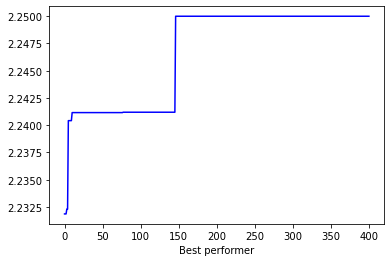

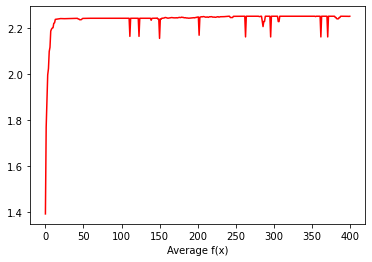

Solutie gasita: 0111111111111101111111  x = 0.49991  f = 2.24999999


In [129]:
# Pentru a rula din nou cu valorile modificate din interfata grafica,
# rulati din nou aceasta celula

# Seteaza hiper-parametrii
setGlobals()

# Rescrie fisier
resetfile(FILENAME)

# Simulare
data = Simuleaza(FILENAME)
myPlot(data)

# Summary
print(f"Solutie gasita: {get_best(data[-1]).tostr()}")

